# Gradient-based localization CAM

Reference: https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam-dogs.ipynb, [paper](https://arxiv.org/abs/1610.02391)

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:

%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
import fastai
fastai.__version__

'1.0.22'

In [5]:
path = untar_data(URLs.PETS); path
bs =64

PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet')

In [6]:
path_anno = path/'annotations'
path_img = path/'images'
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Sphynx_80.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Ragdoll_119.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_80.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_102.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_69.jpg')]

In [8]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [9]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [10]:
# learn.fit_one_cycle(4)

Total time: 04:37
epoch  train_loss  valid_loss  error_rate
1      1.183477    0.293105    0.091340    (01:35)
2      0.487107    0.230847    0.073748    (01:00)
3      0.326659    0.193881    0.061570    (01:00)
4      0.234282    0.185285    0.060216    (01:00)



In [11]:
# learn.save('resnet34-4epochs')

In [11]:
learn.load('resnet34-4epochs');

# CAM implementation

Objective: take outputs of last convo layer (the 7x7x512 layer)

In [12]:
from fastai.callbacks import *

In [13]:
temp=model_sizes(learn.model[0],size=(224,224),full=False)

In [39]:
temp # 8 outputs from 8 blocks of learn.model[0]

[torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 56, 56]),
 torch.Size([1, 64, 56, 56]),
 torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7])]

In [14]:
target_layer = learn.model[0][7][2]
target_layer

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## set up hook for this convo layer

In [33]:
learn = create_cnn(data, models.resnet34, metrics=error_rate);
learn.load('resnet34-4epochs');

In [34]:
target_layer = learn.model[0][7][2]

```
def hook_output (module:nn.Module) -> Hook:  return Hook (module,  lambda m,i,o: o)
```

In [35]:
fmap_hook = hook_output(target_layer)

In [36]:
# gradient hook
gradient_hook = fastai.callbacks.Hook(target_layer, lambda m,inp,out: inp , is_forward=False)
# since we are going backward, we will save input (which is output of convo layer)

# get image

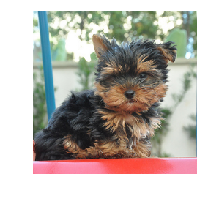

In [37]:
i = 2
learn.data.valid_ds[i][0].show()

In [38]:
imgs, labels = next(iter(learn.data.valid_dl))
img,label = imgs[i],labels[i]


In [39]:
img = img[None,...]
label = label[None,...]
img.shape,label.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

# Run

In [40]:
#important
learn.model.eval();

In [41]:
# forward
learn.model.zero_grad()
out = learn.model(img)

In [42]:
out.shape

torch.Size([1, 37])

In [43]:
out #raw (no softmax)

tensor([[-2.7692, -2.8889, -0.9535,  0.9353, -1.7268, -1.0760,  3.5790, -1.5461,
          4.2168, -4.6671, -5.0911, -3.2297, -2.6304,  1.1238,  0.1578,  2.3039,
         -1.8344, 13.5857, -0.2387, -0.3982, -1.8620,  2.3038, -0.8055,  1.5671,
         -1.9364,  3.1085, -0.1416,  0.0857, -1.2858, -3.1402, -1.2511, -2.1587,
          0.9498, -0.2543, -2.7091, -1.2253,  2.3768]], device='cuda:0',
       grad_fn=<ThAddmmBackward>)

In [44]:
# set the gradients at the output to ones at the predicted class
# and zero everywere else
onehot = torch.zeros(learn.data.c)
onehot[torch.argmax(out)] = 1.0

In [45]:
onehot

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])

In [46]:
onehot.reshape(1, -1).shape

torch.Size([1, 37])

In [47]:
#backprop
out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True) # what is this?
# take the gradient of onehot.reshape(1,-1) instead of out. TODO: try onehot.backward()
# WHY TAKING GRADIENT OF ONE HOT? so that the channels that classify the image label can stand out, and channels that don't will disappear

Let see what is in our hooks

In [48]:
fmap_hook.stored.shape # convo layer output

torch.Size([1, 512, 7, 7])

In [49]:
fmap_hook.stored[0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7225, 1.1795, 0.9575, 0.0147, 0.0000],
        [0.0000, 0.8375, 1.9109, 2.2314, 1.6331, 0.1828, 0.0000],
        [0.0000, 0.3272, 2.3152, 2.2937, 1.7305, 0.0485, 0.0000],
        [0.0593, 1.2982, 2.6599, 1.5780, 0.7278, 0.0000, 0.0000],
        [0.7792, 1.3681, 1.4131, 0.8709, 0.5563, 0.9006, 0.3576],
        [1.1225, 0.2273, 0.0656, 0.2285, 0.2685, 0.7898, 0.2399]],
       device='cuda:0')

In [50]:
gradient_hook.stored

<generator object Hook.hook_fn.<locals>.<genexpr> at 0x7f3fa86882a0>

In [51]:
gradients = next(iter(gradient_hook.stored))  # gradient of onehot w.r.t to convo layer output (7x7x512)
gradients.shape

torch.Size([1, 512, 7, 7])

In [52]:
gradients[0][0]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0009, -0.0009, -0.0009, -0.0009,  0.0000],
        [ 0.0000, -0.0009, -0.0009, -0.0009, -0.0009, -0.0009,  0.0000],
        [ 0.0000, -0.0009, -0.0009, -0.0009, -0.0009, -0.0009,  0.0000],
        [-0.0009, -0.0009, -0.0038, -0.0009, -0.0009,  0.0000,  0.0000],
        [-0.0009, -0.0009, -0.0009, -0.0009, -0.0009, -0.0009, -0.0009],
        [-0.0009, -0.0009, -0.0009, -0.0009, -0.0009, -0.0009, -0.0009]],
       device='cuda:0')

# Calculate heatmap (visualization matrix)

In [53]:
gradient_linearization = gradients.cpu().numpy().sum((2, 3)).reshape(-1) 
# 'add' pooling layer -> flatten. TODO: why pooling layer here? Is it to filter out gradients that does not contribute to
# this image classification?
gradient_linearization.shape

(512,)

In [54]:
fmaps = fmap_hook.stored.cpu().numpy()
fmaps = np.squeeze(fmaps)
fmaps.shape

(512, 7, 7)

In [55]:
# multiply gradient_linearization to fmaps
# heatmap = np.maximum(0, np.einsum('i, ijk',gradient_linearization, fmaps))
heatmap = np.maximum(0, np.sum(gradient_linearization.reshape(gradient_linearization.shape[0],1,1) * fmaps,axis=0))

In [56]:
heatmap

array([[ 0.      ,  0.      ,  0.      ,  0.180685,  0.241103,  0.      ,  0.      ],
       [ 0.      ,  0.42154 ,  3.435369,  5.472353,  5.514501,  3.62066 ,  1.39802 ],
       [ 0.      ,  3.214625,  8.03264 , 12.924706, 12.212349,  9.713263,  4.288159],
       [ 1.274893,  6.079383, 12.627722, 20.528025, 20.016266, 14.152933,  5.756526],
       [ 1.679896,  6.428927, 11.407865, 16.41977 , 15.755603, 10.396656,  4.658196],
       [ 1.431513,  5.12562 ,  8.783388, 10.755799, 10.18433 ,  6.213783,  2.057618],
       [ 0.104485,  1.505989,  3.060753,  3.281574,  2.967617,  0.761524,  0.      ]], dtype=float32)

# scale up the heatmap to image size

In [57]:
7*32

224

In [59]:
import scipy.ndimage

In [60]:
upsampled = scipy.ndimage.zoom(heatmap, 32)
upsampled = (upsampled - np.min(upsampled))/(np.max(upsampled) - np.min(upsampled))

In [61]:
# scale up the heatmap to image size
upsampled

array([[0.005825, 0.005825, 0.005828, 0.005831, ..., 0.005785, 0.005806, 0.00582 , 0.005825],
       [0.005831, 0.005831, 0.005833, 0.005836, ..., 0.00584 , 0.005861, 0.005875, 0.005879],
       [0.005848, 0.005849, 0.00585 , 0.005852, ..., 0.006006, 0.006025, 0.006037, 0.006042],
       [0.005876, 0.005876, 0.005876, 0.005876, ..., 0.006281, 0.006297, 0.006308, 0.006311],
       ...,
       [0.011478, 0.011553, 0.011773, 0.012136, ..., 0.006925, 0.006834, 0.006781, 0.006764],
       [0.011039, 0.011113, 0.011331, 0.011689, ..., 0.006393, 0.00631 , 0.006262, 0.006246],
       [0.01077 , 0.010843, 0.011059, 0.011415, ..., 0.00607 , 0.005991, 0.005946, 0.005931],
       [0.010678, 0.010751, 0.010967, 0.011322, ..., 0.00596 , 0.005884, 0.005839, 0.005825]], dtype=float32)

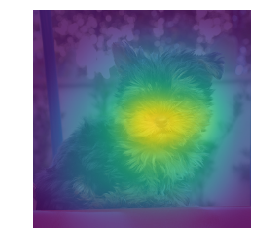

In [62]:
def image_from_tensor(imagetensor):
    numpied = torch.squeeze(imagetensor)
    numpied = np.moveaxis(numpied.cpu().numpy(), 0 , -1)
    numpied = numpied - np.min(numpied)
    numpied = numpied/np.max(numpied)
    return numpied
plt.imshow(image_from_tensor(img))
plt.imshow(upsampled, alpha=.8)
plt.gca().set_axis_off()

Another way to visualize


In [202]:
# #normalize data between 0 and 1
# upsampled2 = (heatmap - heatmap.min())/ (heatmap.max() - heatmap.min())

# upsampled2

# plt.imshow(image_from_tensor(img))
# plt.imshow(scipy.misc.imresize(upsampled2,(224,224)), alpha=.8)

# Guided backprop (TODO)

So, our heatmap above is nice but unfortunately not very fine-grained. We are constrained by the resolution of the feature maps (in our example 7x7).

A first idea would be to naively compute the backprop the gradients of our "forced score" all the way to the image, and see which pixel has higher gradients. So let's do that:

In [63]:
# we ask the model to compute the gradients wrt the image:
img.requires_grad_()

# and then perform our forward and backward passes, forcing the gradient to be 1 for our predicted class
out = learn.model(img)
out.backward(gradient=onehot.reshape(1, -1).cuda());

tensor([[[[ 1.8358e+00,  1.4844e+00,  1.3284e+00,  ...,  5.2869e-01,
            7.2633e-01,  9.2174e-01],
          [ 1.6449e+00,  1.2367e+00,  1.0774e+00,  ...,  3.5750e-01,
            4.9621e-01,  1.1786e+00],
          [ 1.3374e+00,  8.1227e-01,  7.8817e-01,  ...,  9.7436e-02,
            4.6436e-01,  1.3309e+00],
          ...,
          [ 2.1775e+00,  2.2120e+00,  2.1712e+00,  ...,  2.0485e+00,
            2.0210e+00,  2.0798e+00],
          [ 2.1550e+00,  2.1390e+00,  2.1462e+00,  ...,  2.0593e+00,
            2.0611e+00,  2.0606e+00],
          [ 2.1789e+00,  2.1687e+00,  2.1161e+00,  ...,  2.0777e+00,
            2.0717e+00,  2.0463e+00]],

         [[ 2.3715e+00,  2.1794e+00,  2.1196e+00,  ...,  1.2254e+00,
            1.3728e+00,  1.5270e+00],
          [ 2.3545e+00,  2.1437e+00,  1.9533e+00,  ...,  1.0165e+00,
            1.1637e+00,  1.7016e+00],
          [ 2.1412e+00,  1.8045e+00,  1.7333e+00,  ...,  7.1672e-01,
            1.0960e+00,  1.9486e+00],
          ...,
     

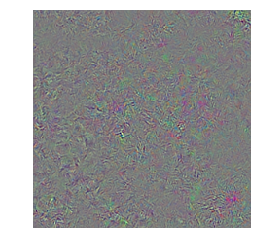

In [211]:
plt.imshow(image_from_tensor(img.grad))
plt.gca().set_axis_off()


That looks horrifying. This because the various neurons interfere with each other during the backpropagation.

The Striving for Simplicity: the All Convolutional Net paper introduced the concept of Guided Backpropagation. The idea, to avoid interference is to simply retain the positive contributions to the gradient while back-propagating, thereby avoiding all interference.

**The idea is to clip all negative gradients at each ReLU layer** . We will do this using the Hooks module in the fastai library

In [64]:
## this callback will make all gradients positive during backprop
def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)

In [65]:

## we inventory all Relu Modules
relu_modules = [module[1] for module in learn.model.named_modules() if str(module[1]) == "ReLU(inplace)"]
len(relu_modules)

18

In [67]:

## and register our hooks with fastai
hooks = fastai.callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False)

In [68]:

learn.model.eval()
img.requires_grad_()
learn.model.zero_grad()
out = learn.model(img);

In [69]:

out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True)

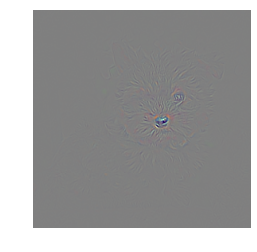

In [70]:
plt.imshow(image_from_tensor(img.grad))
plt.gca().set_axis_off()

To make sure we are only looking at relevant areas of the image, we will multiply this by the heatmap computed using Grad CAM:

In [71]:
gbp =  image_from_tensor(img.grad)

In [72]:
prod = np.einsum('ijk, ij->ijk',gbp, upsampled)

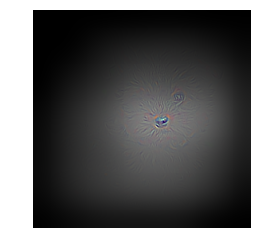

In [73]:
plt.imshow(prod)
plt.gca().set_axis_off()

## Extra: Einstein summation convention

In [162]:
a=np.random.randint(3,size=(3,2,2))
a

array([[[2, 0],
        [2, 0]],

       [[0, 1],
        [0, 1]],

       [[0, 0],
        [0, 2]]])

In [164]:
b = np.random.randint(5,size=(3,))
b

array([3, 2, 3])

In [165]:
np.einsum('i, ijk',b, a)

array([[6, 2],
       [6, 8]])

In [177]:
np.sum(b.reshape(3,1,1)*a,axis=0)

array([[6, 2],
       [6, 8]])